# Determining the Effect of Earlier Weaning off Mechanical Ventilation
This project aims to use causal inference to estimate the effects of weaning patients off mechanical ventilation sooner than normal, following the approach described in [Kennedy, 2018](https://arxiv.org/pdf/1704.00211.pdf). In our dataset we consider patients who have been on mechanical ventilation for 24 hours (our start criteria).

# Determining the Effect of Earlier Weaning off Mechanical Ventilation
This project aims to use causal inference to estimate the effects of weaning patients off mechanical ventilation sooner than normal, following the approach described in [Kennedy, 2018](https://arxiv.org/pdf/1704.00211.pdf). In our dataset we consider patients who have been on mechanical ventilation for 24 hours (our start criteria).

In [ ]:
import pickle
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ALL_WEANING_PREDICTORS is a list of all covariates intially identified as potentially useful in predicting probability of weaning
# group_by_stay is a helper function that groups a dataframe by the column 'stay_id'
from common import (
    ALL_WEANING_PREDICTORS,
    create_calibration_curve,
    group_by_stay,
    remove_extremes,
    remove_outliers
)

np.random.seed(0)

First, we exclude variables from consideration if they are missing more than 10% of the time in post-baseline times. Post-baseline in this case means we filter out records from patients at time points before our start criteria.

```
>>> full_df = pd.read_csv('full_weaning_dataset.csv')
>>> post_baseline_df = full_df.loc[full_df['hour_baseline'] >= 0]
>>> post_baseline_df.to_csv('post_baseline_weaning.csv')
```
We sample a subset of patiets from this post-baseline dataframe and use that as our dataset for this notebook.
```
>>> stay_ids = post_baseline_df['stay_id'].unique()
>>> print(len(stay_ids))
8055
```
Get a random sample of about 5% of the stay_ids.
```
>>> stays = np.random.choice(stay_ids, size=500)
>>> sampled_df = post_baseline_df.loc[post_baseline_df['stay_id'].isin(stays)]
>>> sampled_df.to_csv('sampled_post_baseline.csv')
```

In [2]:
df = pd.read_csv('post_baseline_weaning.csv')

In [2]:
# Load in the sampled dataset
# df = pd.read_csv('sampled_post_baseline.csv')

Before testing which variables are missing, we fill missing urine output (`urine_output`) and vasopressor (`rate_std`) values with 0, since missing entries for these two columns means the value is 0 in this dataset. We do this to make sure we don't exclude the columns from the dataset when we shouldn't.

In [3]:
df.loc[:, ['urine_output', 'rate_std']] = df[['urine_output', 'rate_std']].fillna(0)

Then, we forward fill all columns except for `amount` on a per-patient basis. Their values may only be measured occasionally, which is fine since the previous measurement of these values is important, not whether they were measured recently.

In [4]:
for c in ALL_WEANING_PREDICTORS:
    if c == 'amount': continue
    df.loc[:, c] = group_by_stay(df, c).ffill()

In [5]:
LEN_DF = len(df)
cols_to_exclude = set()
for c in ALL_WEANING_PREDICTORS:
    na_proportion = df[c].isna().sum() / LEN_DF
    if na_proportion >= 0.1:
        cols_to_exclude.add(c)
        print(f'{c}: {round(na_proportion, 3)}')

fio2: 0.21
carboxyhemoglobin: 0.95
methemoglobin: 0.954
ALBUMIN: 0.214
BANDS: 0.632
BILIRUBIN: 0.115
marital_status: 0.124


Now that we've identified which columns should be excluded from our analysis, we can create a new list of predictors.

In [7]:
weaning_predictors = [c for c in ALL_WEANING_PREDICTORS if c not in cols_to_exclude]

# If a column for the measurement of a given value at time t-1 exists, add it to the predictors
for c in weaning_predictors:
    try:
        df['last_' + c]
        weaning_predictors.append('last_' + c)
    except KeyError:
        pass

The next step is to process the data and remove outliers. The `remove_outliers` function essentially writes over implausible values with NaN.

In [9]:
df.loc[:, 'amount'] = df['amount']/1000
df.loc[:, 'last_amount'] = df['last_amount']/1000

remove_outliers(df)

Now, we'll standardize our predictors.

In [10]:
# Standardize predictors
numeric = df[weaning_predictors].select_dtypes(exclude='object').columns
df.loc[:, numeric] = StandardScaler().fit_transform(df[numeric])
# Sanity check to make sure the DataFrame was actually standardized
df[numeric].agg(['mean', 'std']).T

,mean,std
tidal_volume_set,-1.481340e-15,1.000000
tidal_volume_observed,1.890011e-16,1.000000
plateau_pressure,-1.341404e-15,1.000000
ventilator_type,-1.498263e-16,1.000000
peep_set,4.947740e-19,1.000000
...,...,...
last_BUN,2.126035e-16,1.000000
last_WBC,1.270951e-15,1.000000
last_urine_output,6.301787e-17,1.000001
last_GLUCOSE,2.893596e-16,1.000000


Before modeling the probability of weaning, we'll impute medians and remove extreme values from the covariates.

In [11]:
for c in numeric:
    df.loc[:, c].fillna(df[c].median(), inplace=True)

remove_extremes(df)

The final step before modeling is to define our training data. Since we're interested in predicting the probability of starting the first weaning attempt, the relevant data is every timestep up until and including the true start of the first weaning attempt.

For context, any commented-out code in the following cells represents what was/would be run had the notebook used the full dataframe instead of a sampled dataframe.

In [13]:
num_days_off_ctrl = group_by_stay(df, 'control').transform(
    lambda x: (x == 0).cumsum()
)
df = df.loc[num_days_off_ctrl <= 1]

df.to_csv('processed_data.csv')

In [15]:
MODEL_PARAMS = {
    'penalty': 'l2',
    'max_iter': 2000,
}
# Dataframe checkpoint
# df = pd.read_csv('processed_data.csv')

X = df.loc[:, weaning_predictors]
y = df.loc[:, 'control']

for col in X.select_dtypes(include='object'):
    X.loc[:, col] = LabelEncoder().fit_transform(X[col])

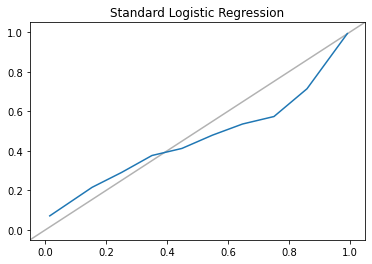

In [23]:
# weaning_predictor = LogisticRegression(**MODEL_PARAMS).fit(X, y)
# with open('models/weaning_predictor.pkl', 'wb') as f:
#     pickle.dump(weaning_predictor, f)

# Load in a LogisticRegression model fitted on the full dataset
with open('models/weaning_predictor.pkl', 'rb') as f:
    weaning_predictor = pickle.load(f)

create_calibration_curve(
    weaning_predictor, X, y,
    'Standard Logistic Regression',
    save_path='images/calibration_curve.png'
)

Train a calibrated regressor since the above graph shows that the current predictor is poorly calibrated.

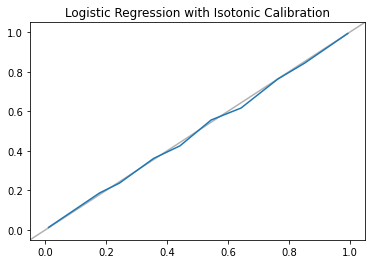

In [24]:
# calibrated_predictor = CalibratedClassifierCV(
#     base_estimator=LogisticRegression(**MODEL_PARAMS),
#     method='isotonic'
#     ).fit(X, y)

# with open('models/calibrated_predictor.pkl', 'wb') as f:
#     pickle.dump(calibrated_predictor, f)

# Load in a calibrated LogisticRegression model fitted on the full dataset
with open('models/calibrated_predictor.pkl', 'rb') as f:
    calibrated_predictor = pickle.load(f)

create_calibration_curve(
    calibrated_predictor, X, y, 
    'Logistic Regression with Isotonic Calibration',
    save_path='images/isotonic_calibration_curve.png'
)

With our well-calibrated model for the probability of weaning, we can now estimate the causal effect of incrementing this propensity score.

In [58]:
# For each value of delta:

# 1. Construct time-dependent weights W_t for each subject and timepoint
# 2. Calculate cumulative product weight for each subject across timepoints
# 3. Multiply each cumulative product weight by the outcome
# 4. Take the average of these products to estimate the mean counterfactual outcome

# Create a column with the propensity of a subject at a given timepoint to begin weaning
df.loc[:, 'propensity_score'] = calibrated_predictor.predict_proba(X)[:, 0]

# Create a column tracking whether weaning has begun or not
df.loc[:, 'weaning'] = (df['control'] == 0).astype(int)

def calculate_estimates(
    deltas,
    data=df,
    treatment_col='weaning',
    propensity_col='propensity_score',
    outcome_col='hospital_expire_flag'
    ):
    """
    Calculate estimates for the effect on `outcome_col` of intervening on `A`
    """
    data = data.copy()
    results = {}
    for delta in deltas:
        A = data[treatment_col]
        pi_hat = data[propensity_col]
        weight_col = f'weights_d{delta}_{outcome_col}'
        # construct time-dependent weights for each subject at each timepoint
        data.loc[:, weight_col] = (
            ((delta * A) + 1 - A) /
            ((delta * pi_hat) + 1 - pi_hat)
        )
        # calculate cumulative product of weights
        cumulative_products = group_by_stay(data, weight_col).prod()
        # truncate cumulative weights at the 99th percentile
        max_val = cumulative_products.quantile(q=0.99)
        cumulative_products = np.minimum(cumulative_products, max_val)
        # multiply by outcome
        weighted_products = cumulative_products.multiply(
            group_by_stay(data, outcome_col).first()
        )
        # average over subjects and add to results
        results[delta] = weighted_products.mean()
    return results


delta_vals = np.around(np.arange(0.5, 2.1, 0.1), decimals=1) # round to remove floating point errors

results = calculate_estimates(delta_vals)

pprint(results)

{0.5: 0.3643007739410494,
 0.6: 0.36421593701509786,
 0.7: 0.3634146007460902,
 0.8: 0.36220445256056355,
 0.9: 0.36081761237349447,
 1.0: 0.3593241357929006,
 1.1: 0.3574718748501072,
 1.2: 0.35576773627641306,
 1.3: 0.35414893542362286,
 1.4: 0.3525811443033539,
 1.5: 0.3510452519213743,
 1.6: 0.34953054812140316,
 1.7: 0.3480310721138083,
 1.8: 0.34654358992180184,
 1.9: 0.3450664433840658,
 2.0: 0.3435988814473932}


To get a better idea of the results, we'll plot a line graph of the estimated outcomes for each value of delta.

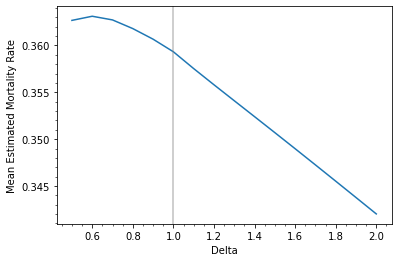

In [57]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Mortality Rate')
plt.plot(results.keys(), results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.minorticks_on()
plt.savefig('images/mortality_results.png', facecolor='white')
plt.show()

Next: bootstrap to determine variability.

In [47]:
N_BOOTSTRAPS = 25
outcome_estimates = {d: [] for d in delta_vals}

stays = df['stay_id'].unique()

def get_bootstrap_sample():
    """Randomly sample from the dataframe, keeping the number of stays the same."""
    sampled_stays = np.random.choice(stays, size=stays.shape, replace=True)
    # Determine how many times each stay should be repeated (since we sample w/replacement)
    num_repeats = {s: 0 for s in sampled_stays}
    for s in sampled_stays:
        num_repeats[s] += 1
    # Choose only the selected stays
    curr_data = df.loc[df['stay_id'].isin(sampled_stays)]
    indices = []
    for stay, idxs in group_by_stay(curr_data).groups.items():
        indices += (num_repeats[stay] * list(idxs))
    return curr_data.reindex(indices)

for i in range(N_BOOTSTRAPS):
    r = calculate_estimates(
        delta_vals,
        data=get_bootstrap_sample()
    )
    for delta, estimate in r.items():
        outcome_estimates[delta].append(estimate)

outcome_estimates = pd.DataFrame(outcome_estimates)
# outcome_estimates.to_csv('outcome_estimates.csv')
outcome_estimates.head()

,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
0,0.416658,0.394455,0.379731,0.370468,0.364566,0.360982,0.358191,0.356961,0.356619,0.356836,0.357437,0.358316,0.359403,0.360653,0.362034,0.363519
1,0.381054,0.374226,0.368726,0.364702,0.361801,0.359774,0.358011,0.357035,0.356535,0.356347,0.356368,0.356550,0.356847,0.357229,0.357676,0.358173
2,0.410796,0.390302,0.376882,0.367855,0.361892,0.358091,0.355279,0.353908,0.353426,0.353558,0.354135,0.355012,0.356161,0.357515,0.359034,0.360686
3,0.405977,0.388406,0.376205,0.368413,0.363711,0.361057,0.359332,0.358904,0.359246,0.360104,0.361309,0.362762,0.364399,0.366173,0.368054,0.370015
4,0.407890,0.387024,0.373697,0.365501,0.360577,0.357879,0.356163,0.355855,0.356396,0.357493,0.358985,0.360773,0.362792,0.364995,0.367347,0.369821


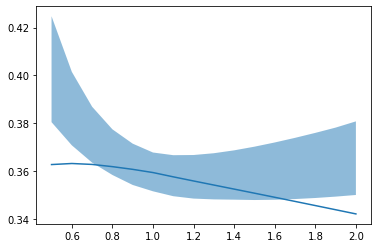

In [48]:
bounds = outcome_estimates.min(), outcome_estimates.max()
plt.fill_between(delta_vals, bounds[0], bounds[1], alpha=0.5)
plt.plot(results.keys(), results.values())
plt.show()

Now that we have an understanding of the variability of our estimates, we'll run one final analysis. This time, instead of looking at the impact of weaning interventions on mortality, our outcome of interest will be the amount of time until first weaning attempt. The goal of this is to see how much of an impact the interventions actually have on the time before first attempt.

In [49]:
grouped = group_by_stay(df, 'weaning')
df['time_until_wean'] = (grouped
    # Apply the .max() and .size() functions to the weaning groups
    # This determines 1. whether weaning occured
    # and 2. the number of hours at which weaning began (if it did)
    .agg(['max', 'size'])
    # If weaning did occur, return the number of hours after baseline with it occured
    # Otherwise, we set the value to 720 hours
    .apply(lambda row: row['size'] if row['max'] else 720, axis=1)
    # Repeat rows to ensure the size of the array matches what's in the dataframe
    .repeat(grouped.size())
    # Reset index so column can be inserted into the dataframe properly
    .reset_index(drop=True)
)

In [50]:
time_until_wean_results = calculate_estimates(delta_vals, outcome_col='time_until_wean')
pprint(time_until_wean_results)

{0.5: 137.6536260966755,
 0.6: 139.42284686579748,
 0.7: 140.6121040157294,
 0.8: 141.3914986182699,
 0.9: 141.9207558664378,
 1.0: 142.2307692307695,
 1.1: 142.2920858100387,
 1.2: 142.25866427739496,
 1.3: 142.14079989035972,
 1.4: 141.9483248593532,
 1.5: 141.69024998319,
 1.6: 141.37466450220705,
 1.7: 141.00875187637743,
 1.8: 140.59885457233509,
 1.9: 140.15055614181117,
 2.0: 139.6687656850366}


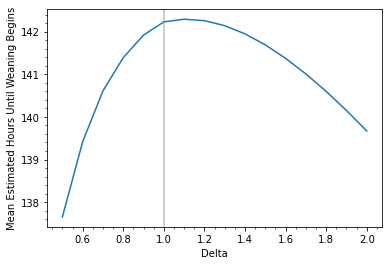

In [55]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Hours Until Weaning Begins')
plt.plot(time_until_wean_results.keys(), time_until_wean_results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.minorticks_on()
plt.savefig('images/time_until_wean_results.png', facecolor='white')
plt.show()

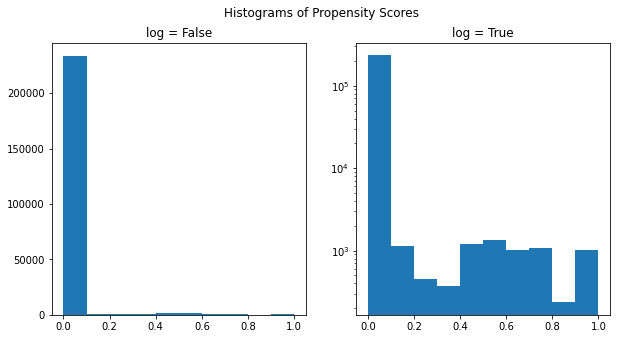

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].hist(df['propensity_score'])
axs[0].set_title('log = False')
axs[1].set_title('log = True')
axs[1].hist(df['propensity_score'], log=True)
fig.suptitle('Histograms of Propensity Scores')
plt.savefig('images/propensity_scores.png', facecolor='white')
plt.show()